## 一、计算机视觉任务类型与边界（分类 vs 检测）

### 1. 图像分类（Image Classification）
- **任务目标**：判断**整张图像**属于哪个预定义类别。
- **输入 → 输出**：
  - 输入：一张图像（如 `256×256×3`）
  - 输出：一个类别标签（如 `"non_compliant"`）或概率分布
- **电力场景示例**：
  - 二分类：`合规` / `不合规`
  - 多分类：`戴安全帽` / `未戴安全帽` / `未穿绝缘服`
- **特点**：**不关心目标位置**，只需整体判断。

### 2. 目标检测（Object Detection）
- **任务目标**：在图像中**定位并识别多个目标**，每个目标需给出**类别 + 位置**。
- **输入 → 输出**：
  - 输入：一张图像
  - 输出：N 个检测结果，每个包含：
    - 类别（如 `"safety_helmet"`）
    - 边界框（Bounding Box）：`(x_min, y_min, x_max, y_max)` 或 `(center_x, center_y, width, height)`
    - 置信度（Confidence Score）
- **电力场景示例**：
  - 检测图中所有人员、安全帽、绝缘手套的位置与类别；
  - 判断“某人是否戴安全帽”需通过**人与安全帽的空间关系**推理。
- **特点**：**需精确位置信息**，适用于多目标、细粒度监督场景。

> ✅ **如何判断竞赛任务类型**？
> - 若题目要求“判断整张图是否合规” → **分类**
> - 若题目要求“标出所有未戴安全帽的人员位置” → **检测**

---

## 二、数据标注：内容、格式与存储方式（核心对比）

### 📌 通用原则
- 标注必须**清晰、一致、无歧义**；
- 标注工具需符合组委会要求（如 LabelImg、CVAT、自研平台）；
- 文件命名、目录结构需严格遵循竞赛规范。

---

### 1. 图像分类标注

#### （1）标注内容
- **仅需图像级标签**（image-level label）
- 示例：  
  - 图像 `img_001.jpg` → 标签：`non_compliant`

#### （2）存储格式（两种主流）


| 方式 | 结构 | 优点 | 适用场景 |
|------|------|------|--------|
| **① 文件夹结构** | <br>├── compliant/<br>│   └── img_001.jpg<br>└── non_compliant/<br>│   └── img_002.jpg | 简单直观，PyTorch `ImageFolder` 直接支持 | 小规模、本地训练 |
| **② CSV/JSON 标签文件** | <br>image_path,label<br>images/img_001.jpg,non_compliant<br>images/img_002.jpg,compliant | 灵活，支持云存储、多标签 | 大规模、复杂任务 |

> ✅ **建议**：优先使用 **文件夹结构**，除非题目明确要求 CSV。

---

### 2. 目标检测标注

#### （1）标注内容
- 对图中**每个目标**标注：
  - **类别名称**（如 `"person"`, `"safety_helmet"`）
  - **边界框**（Bounding Box）坐标
- **边界框格式**（两种常见）：

| 格式 | 描述 | 示例 |
|------|------|------|
| **① Pascal VOC (xmin, ymin, xmax, ymax)** | 左上角 + 右下角像素坐标 | `(50, 100, 200, 300)` |
| **② YOLO (center_x, center_y, width, height)** | **归一化**后的中心点 + 宽高（值 ∈ [0,1]） | `(0.5, 0.6, 0.3, 0.4)` |

> 🔍 **YOLO 格式计算示例**（图像宽=640, 高=480）：  
> 真实框：`(xmin=100, ymin=120, xmax=300, ymax=240)`  
> → `center_x = (100+300)/2 / 640`  
> → `center_y = (120+240)/2 / 640`  
> → `width = (300-100) / 640`  
> → `height = (240-100) / 640`

#### （2）存储格式

| 方式 | 结构 | 说明 |
|------|------|------|
| **① YOLO 格式（推荐）** | - 图像：`images/img_001.jpg`<br>- 标签：`labels/img_001.txt`<br><br>labels/img_001.txt 内容：<br>0 0.3125 0.375 0.3125 0.25<br>1 0.7 0.5 0.2 0.3 | 每行：`class_id center_x center_y width height`<br>class_id 从 0 开始 |
| **② Pascal VOC (XML)** | Annotations/<br>└── img_001.xml | XML 文件包含多个 `<object>`，含类别和坐标 |
| **③ COCO (JSON)** | 单个 `annotations.json` 包含所有图像标注 | 适合大规模数据集，但解析复杂 |

> ✅ **建议**：  
> - 若使用 YOLO 系列模型（如 YOLOv5/v8）→ **必须用 YOLO 格式**  
> - 若提供标注平台 → **按平台导出格式为准**

---

## 三、数据预处理与增强（分类 vs 检测差异）

| 项目 | 图像分类 | 目标检测 |
|------|--------|--------|
| **增强自由度** | 高（可旋转、裁剪、翻转） | **受限**（增强需同步修改边界框） |
| **水平翻转** | ✅ 安全 | ✅ 需同步翻转 bbox（x → 1-x） |
| **旋转** | ✅ | ⚠️ 需重算 bbox，可能变四边形（YOLO 不支持） |
| **随机裁剪** | ✅ | ⚠️ 需保留目标，否则丢失标签 |
| **颜色增强** | ✅ | ✅（不影响 bbox） |
| **常用工具** | `torchvision.transforms` | `albumentations`（自动同步 bbox） |

> 💡 **关键区别**：  
> - 分类增强只改图像；  
> - 检测增强必须**图像 + 标注同步变换**！

---

## 四、模型与输出结构对比

| 项目 | 图像分类 | 目标检测 |
|------|--------|--------|
| **典型模型** | ResNet, EfficientNet | YOLOv5/v8, Faster R-CNN |
| **输入** | `[B, 3, H, W]` | `[B, 3, H, W]` |
| **输出** | `[B, C]` logits | 多尺度特征图 → 解码为 `(x, y, w, h, conf, cls)` |
| **损失函数** | CrossEntropyLoss | 复合损失（定位 loss + 分类 loss + 置信度 loss） |
| **评估指标** | Accuracy, F1, Recall | mAP (mean Average Precision) |

---

## 五、部署输出格式对比

| 任务 | 输出 JSON 示例 |
|------|----------------|
| **分类** | <br>{<br>  "predicted_class": "non_compliant",<br>  "confidence": 0.92<br>} |
| **检测** | <br>{<br>  "detections": [<br>    {"class": "person", "bbox": [50,100,200,300], "score": 0.95},<br>    {"class": "safety_helmet", "bbox": [60,110,180,220], "score": 0.88}<br>  ]<br>} |


# 📌 图像分类基础概念

图像分类是计算机视觉中最基础且广泛应用的任务之一，其目标是**根据图像内容自动判断其所属的预定义类别**。例如，在电力作业安全监督场景中，我们可以训练一个模型，自动判断一张现场照片是否“合规”（如人员正确佩戴安全帽、穿戴绝缘服等），从而实现高效、自动化的安全巡检。

### 🔍 典型流程
一个完整的图像分类项目通常包含以下几个关键环节：

1. **数据准备**  
   - 收集并清洗图像数据，剔除模糊、无关或标注错误的样本；
   - 按类别组织数据（如文件夹结构或标签文件），确保类别定义清晰、无歧义。

2. **数据增强（Data Augmentation）**  
   - 通过对原始图像进行旋转、裁剪、亮度调整等操作，人工扩展训练数据，提升模型泛化能力，防止过拟合。

3. **模型选择与训练**  
   - 选用合适的深度学习架构（如 ResNet、EfficientNet、Vision Transformer 等）；
   - 在训练集上学习图像特征与类别之间的映射关系，并在验证集上评估性能。

4. **模型评估**  
   - 使用准确率（Accuracy）、精确率（Precision）、召回率（Recall）、F1 分数等指标衡量模型效果；
   - 特别关注**关键类别**（如“不合规”）的识别能力，在安全场景中，漏报（False Negative）往往比误报代价更高。

5. **模型部署**  
   - 将训练好的模型封装为服务，接收图像输入（通常为 base64 编码），返回分类结果与置信度；
   - 在实际系统中实现端到端的自动化判断。

## 1.1 工具包导入

In [1]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 38.6 MB/s eta 0:00:00:00:010:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

In [2]:
import torch
torch.manual_seed(0)  # 设置随机种子以确保结果可重复
torch.backends.cudnn.deterministic = False  # 允许某些非确定性操作，以提高训练速度
torch.backends.cudnn.benchmark = True  # 允许CUDNN自动寻找最优的算法，以提高训练速度

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from pathlib import Path
import timm  # 提供了大量的预训练模型
import time
import pickle
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook  # 用于显示训练和验证过程的进度条
import timm

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2225: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

## 1.2 定义计算平均指标和显示进度的类
`AverageMeter`类用于计算并存储平均值和当前值，`ProgressMeter`类用于显示训练和验证过程的进度。


In [3]:
# 定义一个计算并存储平均值和当前值的类
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


# 定义一个显示进度的类
class ProgressMeter(object):
    def __init__(self, num_batches, *meters):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = ""

    def pr2int(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

## 1.3 定义数据加载类
`FFDIDataset`类用于加载数据集。`__init__`方法用于初始化数据集，`__getitem__`方法用于获取数据集中的样本，`__len__`方法用于获取数据集的长度。
`__init__`方法接受`img_path`和`img_label`作为输入，`transform`参数用于对图像进行预处理。

In [4]:
class FFDIDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(np.array(self.img_label[index]))
    
    def __len__(self):
        return len(self.img_path)

## 1.4 定义数据加载和预处理
这一部分定义了数据加载和预处理的过程。首先，读取训练和验证数据的标签文件，然后生成训练和验证数据的路径。接着，定义了训练和验证数据加载器，使用`torch.utils.data.DataLoader`加载数据集，并对图像进行预处理。

此外对于训练集还使用了随机数据增强操作来动态扩充数据集。

In [5]:
# 读取训练和验证数据的标签文件
trainset_path = Path("/kaggle/input/intel-image-classification/seg_train/seg_train")
image_paths, image_labels = [], []
for path in trainset_path.glob("**/*.jpg"):
    image_paths.append(str(path))
    image_labels.append(str(path.parent.stem))

# 使用label encoder将字符串类转为数值类型
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
image_labels = encoder.fit_transform(image_labels)
with open("label_encoder.pkl", 'wb') as f:
    pickle.dump(encoder, f)

In [6]:
set(image_labels)

{0, 1, 2, 3, 4, 5}

In [7]:
# 读取测试数据的标签文件
testset_path = Path("/kaggle/input/intel-image-classification/seg_test/seg_test")
test_image_paths, test_image_labels = [], []
for path in testset_path.glob("**/*.jpg"):
    test_image_paths.append(str(path))
    test_image_labels.append(str(path.parent.stem))

# 使用label encoder将字符串类转为数值类型
from sklearn.preprocessing import LabelEncoder

test_image_labels = encoder.transform(test_image_labels)

In [8]:
bs_value = 32  # 批次大小：平衡训练速度与显存占用，32 是常用值

# ==============================
# 训练集数据增强策略（针对电力作业图像优化）
# ==============================
train_set_transform = transforms.Compose([
    # 1. 统一输入尺寸：确保所有图像缩放到相同分辨率
    #    注意：Resize((256, 256)) 会拉伸图像，若需保持宽高比，可改用 Resize(256) + CenterCrop(224)
    transforms.Resize((256, 256)),
    
    # 2. 【核心增强】RandAugment：自动组合多种增强操作，适合分类任务
    #    - num_ops=2：每次应用 2 种增强操作
    #    - magnitude=9：增强强度（0~30），9 为中等偏强，适用于安全场景多样性需求
    transforms.RandAugment(num_ops=2, magnitude=9),
    
    # ==============================
    # 【可选增强】以下为补充增强方法（可按需取消注释）
    # ==============================
    
    # 随机水平翻转（适用于电力作业场景，人员左右对称通常合理）
    # transforms.RandomHorizontalFlip(p=0.5),
    
    # 随机旋转（±10度）：模拟拍摄角度轻微偏移
    # transforms.RandomRotation(degrees=10),
    
    # 随机裁剪并缩放回原尺寸：提升模型对局部特征的鲁棒性
    # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    
    # 颜色抖动：模拟光照变化（电力现场光照条件复杂）
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.05),
    
    # 随机擦除（CutOut）：提升对局部遮挡的鲁棒性（如安全帽被遮挡）
    # transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False),
    
    # 3. 转换为 PyTorch 张量（HWC → CHW，像素值 [0,255] → [0,1]）
    transforms.ToTensor(),
    
    # 4. 归一化：使用 ImageNet 统计值，便于迁移学习（若使用预训练模型）
    #    mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==============================
# 训练数据加载器
# ==============================
train_loader = torch.utils.data.DataLoader(
    FFDIDataset(image_paths, image_labels, train_set_transform),
    batch_size=bs_value,
    shuffle=True,          # 每个 epoch 打乱数据，防止过拟合
    num_workers=4,         # 多进程加载数据（根据 CPU 核心数调整）
    pin_memory=True        # 锁页内存，加速 GPU 数据传输
)

In [9]:
for image, label in train_loader:
    print(image.shape)
    print(label)
    break

torch.Size([32, 3, 256, 256])
tensor([5, 5, 4, 1, 2, 2, 0, 1, 0, 0, 1, 4, 1, 2, 0, 3, 0, 0, 4, 5, 1, 3, 1, 0,
        0, 0, 0, 4, 3, 4, 4, 2])


In [10]:
# 定义验证数据加载器
val_set_transform = transforms.Compose([
                    transforms.Resize((256, 256)),  # 调整图像大小
                    transforms.ToTensor(),  # 转换为张量
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 归一化
                ])
val_loader = torch.utils.data.DataLoader(
    FFDIDataset(test_image_paths, test_image_labels, val_set_transform), batch_size=bs_value, shuffle=False, num_workers=4, pin_memory=True
)

## 1.5 定义模型
使用`timm`库提供的`create_model`函数创建一个预训练的EfficientNet模型，并将其移动到GPU上。`timm`是一个提供了大量预训练模型的库，可以方便地使用各种模型进行训练和预测。更多信息可以访问[timm GitHub](https://github.com/huggingface/pytorch-image-models)。

In [ ]:
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(set(image_labels)))
model = model.cuda()

## 1.6 定义损失函数和优化器
这一部分定义了损失函数、优化器和学习率调度器。`nn.CrossEntropyLoss`用于计算交叉熵损失，`torch.optim.Adam`用于执行Adam优化算法，`optim.lr_scheduler.StepLR`用于调整学习率。

交叉熵损失函数（Cross-Entropy Loss）是图像分类等任务中最常用的损失函数之一，用于衡量模型预测的概率分布与真实标签之间的差异。

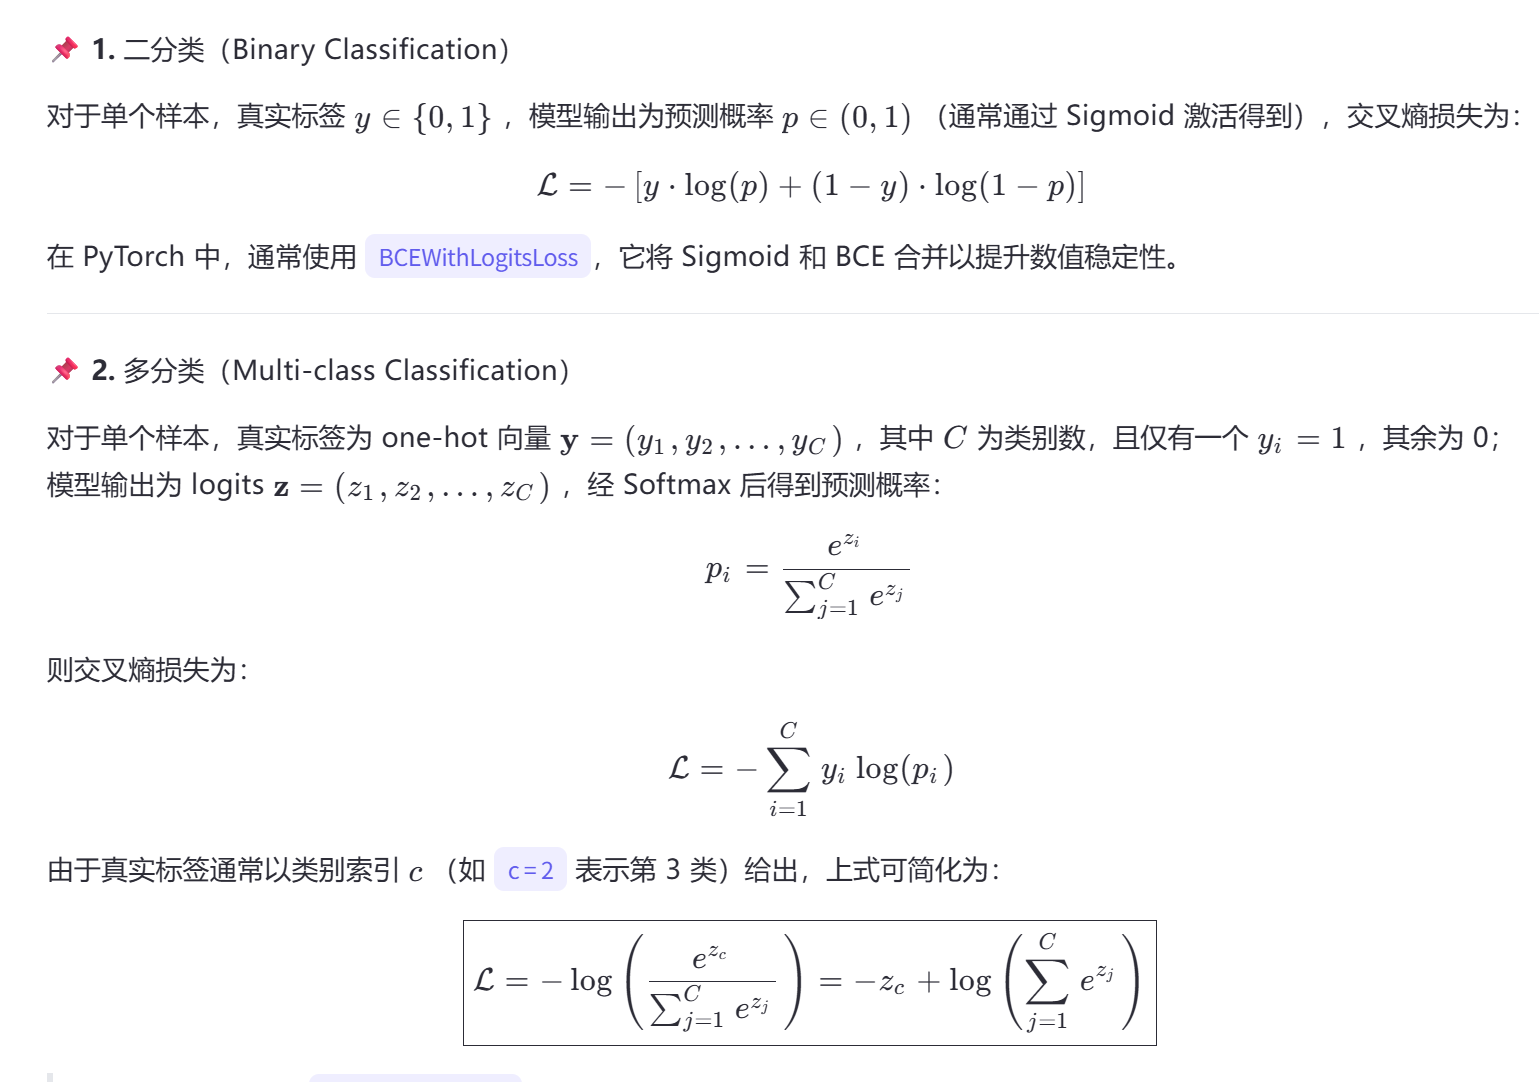

In [ ]:
epoch_num = 1  # 设置训练的总轮数
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(model.parameters(), 0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.85)  # 学习率调度器
best_acc = 0.0  # 初始化最佳准确度

## 1.7 定义训练、验证和预测函数
这一部分定义了训练、验证和预测的函数，包括`train`、`validate`和`predict`函数。这些函数用于训练模型、验证模型和预测测试集的结果。

In [ ]:
# 定义验证过程
def validate(val_loader, model, criterion):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(val_loader), batch_time, losses, top1)

    # 切换到评估模式
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in tqdm_notebook(enumerate(val_loader), total=len(val_loader)):
            input = input.cuda()
            target = target.cuda()

            # 计算输出
            output = model(input)
            loss = criterion(output, target)

            # 计算准确度并记录损失
            acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
            losses.update(loss.item(), input.size(0))
            top1.update(acc, input.size(0))
            # 计算耗时
            batch_time.update(time.time() - end)
            end = time.time()

        # TODO: 这也应该用ProgressMeter来做
        print(' * Acc@1 {top1.avg:.3f}'
              .format(top1=top1))
        return top1


# 定义预测过程
def predict(test_loader, model, tta=10):
    # 切换到评估模式
    model.eval()

    test_pred_tta = None
    for _ in range(tta):
        test_pred = []
        with torch.no_grad():
            end = time.time()
            for i, (input, target) in tqdm_notebook(enumerate(test_loader), total=len(test_loader)):
                input = input.cuda()
                target = target.cuda()

                # 计算输出
                output = model(input)
                output = F.softmax(output, dim=1)
                output = output.data.cpu().numpy()

                test_pred.append(output)
        test_pred = np.vstack(test_pred)

        if test_pred_tta is None:
            test_pred_tta = test_pred
        else:
            test_pred_tta += test_pred

    return test_pred_tta


# 定义训练过程
def train(train_loader, model, criterion, optimizer, epoch):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    progress = ProgressMeter(len(train_loader), batch_time, losses, top1)

    # 切换到训练模式
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        input = input.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # 计算输出
        output = model(input)
        loss = criterion(output, target)

        # 记录损失
        losses.update(loss.item(), input.size(0))

        # 计算准确度
        acc = (output.argmax(1).view(-1) == target.float().view(-1)).float().mean() * 100
        top1.update(acc, input.size(0))

        # 计算梯度并执行优化步骤
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # 计算耗时
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            progress.pr2int(i)

## 1.8 训练模型


In [ ]:
# 训练和验证模型
for epoch in range(epoch_num):
    scheduler.step()  # 更新学习率
    print('Epoch: ', epoch)

    train(train_loader, model, criterion, optimizer, epoch)  # 训练模型
    val_acc = validate(val_loader, model, criterion)  #
    # 验证模型
    if val_acc.avg.item() > best_acc:
        best_acc = round(val_acc.avg.item(), 2)
        torch.save(model.state_dict(), f'./model_{best_acc}.pt')  # 保存表现更好的模型

# 整个保存最终模型
torch.save(model, "last.pt")

## 1.9 模型评估


In [ ]:
import torch
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

print("=" * 60)
print("开始模型评估流程")
print("=" * 60)

all_preds = []
all_labels = []
all_probs = []
class_names = encoder.classes_
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        probs = F.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

# 转为 numpy 数组
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# 1. 整体准确率
acc = accuracy_score(all_labels, all_preds)
print(f"\n✅ 验证集整体准确率 (Accuracy): {acc:.4f} ({acc*100:.2f}%)")

# 2. 详细分类报告
print("\n📋 分类报告 (Classification Report):")
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report)

# 3. 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)
print("🧮 混淆矩阵 (Confusion Matrix):")
print(cm)

# 可视化混淆矩阵
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# 4. 可视化部分预测结果（正确与错误各若干）
print("\n🖼️  预测结果可视化（正确 vs 错误）...")

# 获取部分原始数据用于可视化（需重新遍历或提前保存）
# 这里假设 val_loader 可重复（或使用 Subset），否则建议在评估前缓存少量样本
def visualize_predictions(model, val_loader, class_names, num_show=4):
    model.eval()
    fig, axes = plt.subplots(2, num_show, figsize=(3*num_show, 6))
    correct_count = 0
    error_count = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            for i in range(images.size(0)):
                img = images[i].cpu().permute(1, 2, 0).numpy()
                # 反归一化（若训练时做了归一化）
                # img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
                img = np.clip(img, 0, 1)
                
                true_label = class_names[labels[i].item()]
                pred_label = class_names[preds[i].item()]
                
                if correct_count < num_show and preds[i] == labels[i]:
                    ax = axes[0, correct_count]
                    ax.imshow(img)
                    ax.set_title(f'T: {true_label}\nP: {pred_label}', color='green')
                    ax.axis('off')
                    correct_count += 1
                
                if error_count < num_show and preds[i] != labels[i]:
                    ax = axes[1, error_count]
                    ax.imshow(img)
                    ax.set_title(f'T: {true_label}\nP: {pred_label}', color='red')
                    ax.axis('off')
                    error_count += 1
                
                if correct_count >= num_show and error_count >= num_show:
                    plt.tight_layout()
                    plt.show()
                    return

# 调用可视化（注意：若 val_loader 有 shuffle=True，每次结果不同）
visualize_predictions(model, val_loader, class_names, num_show=4)

print("=" * 60)
print("模型评估流程结束")
print("=" * 60)

## 1.10 模型导入及预测


In [ ]:
# 保存参数导入需要重新建整个模型
model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=len(set(image_labels)))
model.load_state_dict(torch.load(f"/kaggle/working/model_{best_acc}.pt"))
model.cpu()
model.eval()
# 保存全量模型不需要创建模型
best_model = torch.load("/kaggle/working/last.pt", weights_only=False)
best_model.cpu()
best_model = best_model.eval()

In [ ]:
# 在测试集上进行预测
target_image = "/kaggle/input/intel-image-classification/seg_pred/seg_pred/10004.jpg"
# 使用验证集上相同的预处理步骤
img = Image.open(target_image).convert('RGB')        
img = val_set_transform(img)
print(img.shape)

In [ ]:
# 使用tensor对图像第一维多加一个维度
processed_img = img.unsqueeze(0)
# 模型推理
with torch.no_grad():
    output1 = model(processed_img)
    output2 = best_model(processed_img)
    predict1 = torch.argmax(output1).item()
    predict2 = torch.argmax(output2).item()
print("通过参数加载的模型预测结果： ", encoder.inverse_transform([predict1]))
print("通过参数加载的模型预测结果： ", encoder.inverse_transform([predict2]))

## 1.11 通过微服务部署该模型

In [ ]:
import base64
import io
import pickle
from typing import Dict, Any
from PIL import Image
from fastapi import FastAPI, Request, HTTPException
from fastapi.responses import JSONResponse
import torch
import torch.nn.functional as F
from torchvision import transforms

# ==============================
# 1. 配置区（请根据你的训练设置修改）
# ==============================
MODEL_PATH = "last.pt"
ENCODER = pickle.load(open("label_encoder.pkl", 'rb'))
CLASS_NAMES = ENCODER.classes_  # 顺序必须与训练一致
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 与训练/验证集完全一致的预处理
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ==============================
# 2. 初始化 FastAPI App
# ==============================
app = FastAPI(
    title="电力作业安全图像分类 API",
    description="竞赛用模型部署接口，支持 base64 图像输入",
    version="1.0.0"
)

# ==============================
# 3. 加载模型（启动时一次性加载）
# ==============================
print("=" * 60)
print("🚀 正在加载模型，请稍候...")
try:
    # === 替换此处为你的模型定义 ===
    model = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=False)
    model.eval()
    print(f"✅ 模型加载成功！设备: {DEVICE}")
except Exception as e:
    print(f"❌ 模型加载失败: {e}")
    raise
print("=" * 60)


# ==============================
# 4. 核心推理函数（同步，因 PyTorch 推理通常不支持异步）
# ==============================
def _infer_from_base64(base64_str: str) -> Dict[str, Any]:
    """内部推理函数"""
    try:
        # 解码 base64
        image_data = base64.b64decode(base64_str)
        image = Image.open(io.BytesIO(image_data)).convert("RGB")
    except Exception as e:
        raise ValueError(f"图像解码失败: {e}")

    try:
        # 预处理
        input_tensor = transform(image).unsqueeze(0).to(DEVICE)
        
        # 推理
        with torch.no_grad():
            logits = model(input_tensor)
            probs = F.softmax(logits, dim=1).cpu().numpy()[0]
        
        # 构建结果
        pred_idx = int(probs.argmax())
        return {
            "predicted_class": CLASS_NAMES[pred_idx],
            "confidence": round(float(probs[pred_idx]), 4),
            "all_scores": {
                cls: round(float(prob), 4) 
                for cls, prob in zip(CLASS_NAMES, probs)
            }
        }
    except Exception as e:
        raise RuntimeError(f"推理过程出错: {e}")


# ==============================
# 5. API 路由
# ==============================
@app.post("/predict", summary="图像分类预测")
async def predict(request: Request):
    """
    接收 base64 图像，返回分类结果。
    
    **请求体示例**:
    ```json
    {
      "image": "base64_encoded_string"
    }
    ```
    
    **响应示例**:
    ```json
    {
      "predicted_class": "non_compliant",
      "confidence": 0.92,
      "all_scores": {"compliant": 0.08, "non_compliant": 0.92}
    }
    ```
    """
    try:
        # 解析 JSON
        body = await request.json()
        if not isinstance(body, dict) or "image" not in body:
            raise HTTPException(status_code=400, detail="请求体必须包含 'image' 字段")
        
        base64_image = body["image"]
        if not isinstance(base64_image, str):
            raise HTTPException(status_code=400, detail="'image' 必须是字符串")

        # 推理
        result = _infer_from_base64(base64_image)
        
        # 结构化日志
        print("=" * 60)
        print("✅ 推理成功")
        print(f"预测类别: {result['predicted_class']}")
        print(f"置信度: {result['confidence']:.4f}")
        print("=" * 60)
        
        return result

    except ValueError as e:
        error_msg = str(e)
        print(f"\n{'='*60}\n❌ {error_msg}\n{'='*60}")
        raise HTTPException(status_code=400, detail=error_msg)

    except RuntimeError as e:
        error_msg = str(e)
        print(f"\n{'='*60}\n❌ {error_msg}\n{'='*60}")
        raise HTTPException(status_code=500, detail=error_msg)

    except Exception as e:
        error_msg = f"未知错误: {e}"
        print(f"\n{'='*60}\n❌ {error_msg}\n{'='*60}")
        raise HTTPException(status_code=500, detail=error_msg)

In [ ]:
# import uvicorn
# uvicorn.run(app, host="0.0.0.0", port=8000, reload=True)